# Delivery time prediction

Justyna Gibas 403122 <br>
Jan Pomykacz

# Introduction
The goal of our project is to predict food delivery time. Model can be used by companies to estimate delivery time based on distance, order time etc, and notify their customers when food should arrive. Such notification are implemented in services (e.g Pyszne.pl), but often they're incorrect.

# Dataset
In project we use data from Kaggle only from file train.csv (https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset?select=train.csv).  Both numerical and categorical variable are available. Data comes from orders in India. Dataset contain information about:
-	order ID and delivery person ID,
-	delivery person age and rating,
-	coordinates of restaurant,
-	coordinates of delivery location,
-	order date and time,
-	pickup time (by delivery person),
-	weather conditions,
-	traffic,
-	vehicle type and it’s condition,
-	type of food ordered,
-	city type, 
-	information if there is a festival,
-	number of deliveries,
-	number of simultaneously delivered orders,
-	delivery time (in minutes). <br><br>

We don’t take into consideration IDs, information about festivals (are very rare 1-2% of data) and vehicle condition (values aren’t described)



# DAG

On our dag wy used following notation:
- continuous lines - indicates association between block, the thicker it is the stronger association,
- dashed lines - indicates weak influence between data,
- continuous border - data was present in dataset,
- dashed border - data wasn't present in dataset e.g. meal preparation time was calculated based on data,
- white blocks - data wasn't used in models,
- blue blocks -  predictor used in first model,
- yellow blocks -  additional predictors used in second model,
- red block - predicted data.
<br><br>
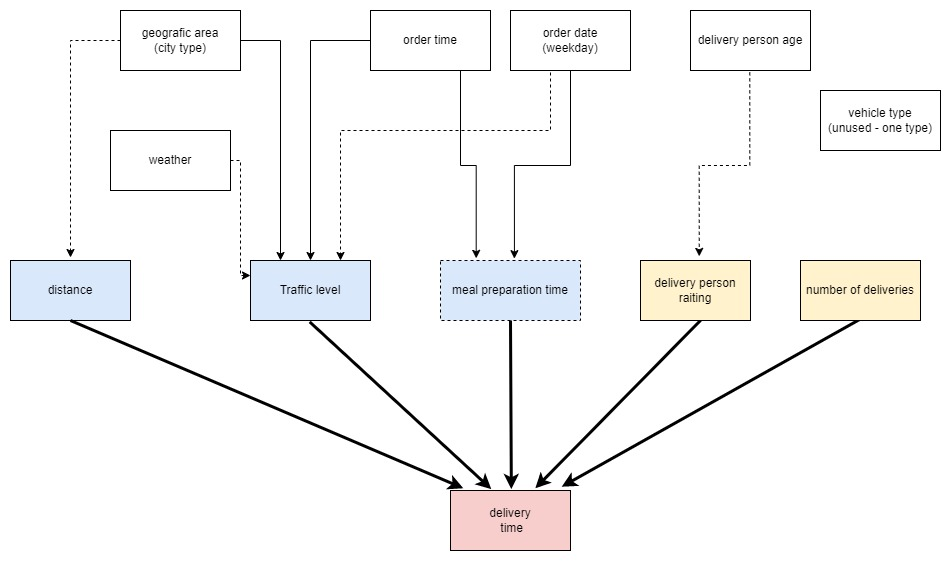

# Possible cofoundings

# Data Preprocessing

To prepare data for modelling and better them understand we take the following  steps:
1.	delete wrong coordinates – Some records contain coordinates that don’t belong to India e.g. ocean point. We remove them due to we can't create road paths between this points.
2.	remove records containing nulls – We don’t consider missing or corrupted predictors/data, because they make prediction impossible.
3.	calculate meal preparation time – There was only date and time for of order and pick up by delivery person. We calculate time in minutes to simplified modelling.
4.	delete impossible delivery times – Some records contain delivery time that is lower or equal to meal preparation time. We assumed that meal preparation time is part of delivery time so those records would have negative travel time.
5.	converting coordinates to road distance – We mapped the coordinates to a distance to better match the actual delivery route.  We used OpenStreetMaps API.  Some created routes have incorrect distances or failed to create.
6.	removing corrupted routes – There were some issue with routing – road distances was lower that straight line distance, so we remove them. 
7.	filtering data – We assumed that maximum delivery distance is around 20 km.  In modelling we used records that have distances lower or equal to 20.
8.  mapping categorical (string) data to numerical – In our models we used categorical value about traffic level, but models cannot use non-numerical predictors. 
9. data standadrization - We have problem with link function (exp), because data is widely spread. We decide to standarize distance, meal preparation time and delivery person ratings for easier modeling and interpretation.
10. remapping multiple_deliveries - We used it as indexical varible so we need to adjust it values to stan indexing - mapped  0-3 to 1-4.  

Note that only filtering, mapping and standardization are done in this notebook.  You can find data after preprocessing (steps 1-6) in file delivery_time_data.csv. 


## The distribution of standardized data 

# Models description

We designed two models  to make a delivery time prediction. Both models using inverse gamma distribution to model the delivery time. In second model we additionally take into account parameters describing delivery person – his/her rating and number of deliveries. In first model we used parameters that we consider most important. The other model is supposed to extedn first one. By adding more parameters (information about delivery) will improve prediction or overcomplicated the model.



## Model 1

### Inputs

N - number of samples <br>
distance - vector conatining standarized distances <br>
traffic_level - numerical array containing infromation about traffic level (1-Jam, 2-High, 3-Medium, 4-Low) <br>
meal_preparation_time - vector containing standarized meal preparation time <br>

### Parameters

$\mu$ - average time of delivery for given parameters, used for calculation of invgamma parameters $\alpha$ and $\beta$ <br>
$\sigma$ - standard deviation of delivery time, used for calculation of invgamma parameters $\alpha$ and $\beta$ <br>
mean - it represents time of average delivery, intercept in link function <br>
distance_coeff - coefficient of distance, used in link function <br>
meal_prep_coeff - coefficient of meal preparation time, used in link function <br>
traffic_level_coeff - vector of traffic level coefficients, used in link function <br>


### Formulas

$$ delivery\_time_{i} \sim InvGamma(\alpha_{i}, \beta_{i})$$
$$ \alpha_i=\frac{\mu_i^2}{\sigma_i^2}+2$$
$$ \beta=\frac{\mu_i^3}{\sigma_i^2}+\mu_i $$
$$ \sigma_i \sim Exponential\left(0.5\right)$$
$$ \mu_i = exp(distance\_coeff_{i} \cdot distance_{i} +  traffic\_level\_coeff[traffic\_level_{i}]\ + meal\_prep\_coeff_{i}\ \cdot  meal\_preparation\_time_{i} + mean_{i}) $$
$$ mean_{i} \sim Normal(3,0.1)$$ 
$$ distance\_coeff_{i}  \sim Normal(0,0.3)$$ 
$$ meal\_prep\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[1] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[2] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[3] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[4] \sim Normal(0,0.3)$$

## Model 2

### Inputs

N - number of samples
distance - vector conatining standardized distances <br>
traffic_level - numerical array containing infromation about traffic level (1-Jam, 2-High, 3-Medium, 4-Low) <br>
meal_preparation_time - vector containing standardized meal preparation times <br>
delivery_person_rating - array containing standardized rating of delivery person <br>
number_of_deliveries - array containing information about additional deliveries <br>

### Parameters
$\mu$ - average time of delivery for given parameters, used for calculation of invgamma parameters $\alpha$ and $\beta$ <br>
$\sigma$ - standard deviation of delivery time, used for calculation of invgamma parameters $\alpha$ and $\beta$  <br>
mean - intercept in link function, it represents time of average delivery <br>
distance_coeff - coefficient of distance, used in link function <br>
meal_prep_coeff - coefficient of meal preparation time, used in link function <br>
traffic_level_coeff - vector of traffic level coefficients, used in link function <br>
person_rating_coeff - coefficient of delivery preson raiting, used in link function<br>
deliveries_number_coeff - vector of coefficients corresponding to number of multiple deliveries, used in link function<br>

### Formulas

$$ delivery\_time_{i} \sim InvGamma(\alpha_{i}, \beta_{i})$$
$$ \alpha_i=\frac{\mu_i^2}{\sigma_i^2}+2$$
$$ \beta=\frac{\mu_i^3}{\sigma_i^2}+\mu_i $$
$$ \sigma_i \sim Exponential\left(0.5\right)$$
$$ \mu_i = exp(distance\_coeff_{i} \cdot distance_{i}+traffic\_level\_coeff[traffic\_level_{i}]\ + meal\_prep\_coeff_{i}\ \cdot  meal\_preparation\_time_{i} + \\ + person\_rating\_coeff_{i} \cdot delivery\_person\_rating_{i} +  deliveries\_number\_coeff[number\_of\_deliveries_{i}] + mean_{i})$$ 
$$ mean_{i} \sim Normal(3,0.1)$$ 
$$ distance\_coeff_{i}  \sim Normal(0,0.3)$$ 
$$ meal\_prep\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff_{i} \sim Normal(0,0.3)$$
$$ person\_rating\_coeff_{i} \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[1] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[2] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[3] \sim Normal(0,0.3)$$
$$ traffic\_level\_coeff[4] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[1] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[2] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[3] \sim Normal(0,0.3)$$
$$ deliveries\_number\_coeff[4] \sim Normal(0,0.3)$$

# Model 1 - Priors 

We decided to choose weakly inforfmative priors, becuse we have a lot of data. As the number of datapoint incerased, priors have less and less influecne on the model. We have standardized data, so for most of parameters we choose normal distribution with mean=0. Standard deviation is 0.3 so the exponent doesn't get high values. <br>
Parameter mean is intercept for link function representing time of average delivery. Selected priors give most of times of average delivery as 15-27 minutes.




# Model 1 - Posterior


## Issuses
During sampling we had the following issues:
- poor sampling algorithm performace (high R-hat values, divergent transitions, low  E-BFMI values)
- jupter krenel crashes <br>

We used CmdStan tool diagnose() to investigate sampling problems and possible solutions.We increased number of warmup iteration, number of sampling iteration and removed wrong constraints. <br>

We also had problems with jupyter kernel. While sampling all possible data (firstly we used only 1000 records) it crashes. To overcome it we prepared Python scripts that sample model's data and save results to csv files. CmdStan allowes to reproduce models from those files.

# Model 2 - Priors 

# Model 2 - Posterior

## Issuses
While sampling we have similar issue like in first model - jupter krenel crashes. We have prepared an analogous script as for the first model.

# Model comparison

We compare models using WAIC and PSIS-LOO information criteria. 

### WAIC 

### LOO

Models performance is similar. Based on histograms is hard to indicate better model, but both information criteria pointed that model 2 gives better results. Adding information about courier and number of extra deliveries to model improve prediction.